In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")   

sklearn version:  0.24.2
TF version:  2.6.2
No GPU was detected. CNNs can be very slow without a GPU.
GPU installed:  True


In [2]:
import tensorflow as tf
from tensorflow import keras

In [4]:
# file이 있는 path로 이동
os.chdir("./emnist")
# os.chdir('/content/drive/MyDrive/ANN/') 

In [6]:
# Load EMNIST dataset
import pandas as pd
# import gzip

byclass_train = pd.read_csv("./emnist-byclass-train.csv")
byclass_test = pd.read_csv("./emnist-byclass-test.csv")
mapp = pd.read_csv("./emnist-byclass-mapping.txt", 
                   delimiter = ' ', index_col=0, header=None, squeeze=True)

In [7]:
# DataFrame
byclass_train.shape

(697931, 785)

In [8]:
byclass_train.head()

,35,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.466,0.467,0.468,0.469,0.470,0.471,0.472,0.473,0.474,0.475
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
byclass_test.shape

(116322, 785)

In [10]:
byclass_test.head()

,18,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.652,0.653,0.654,0.655,0.656,0.657,0.658,0.659,0.660,0.661
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
classes = len(byclass_train['35'].value_counts())
print('number of classes: ', classes)

number of classes:  62


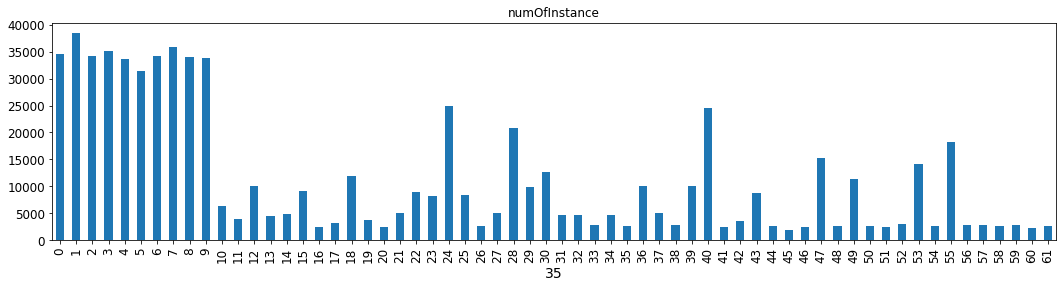

In [12]:
(byclass_train.groupby(['35']).size()).plot(kind='bar', figsize=(18, 4))
plt.title('numOfInstance')
plt.show()

In [ ]:
# 30분 이상 소요..

from sklearn.manifold import TSNE

image_tsne = TSNE(n_components=2).fit_transform(balanced_train)

In [ ]:
# seaborn lib 설치 필요

import seaborn as sns

plt.figure(figsize=(16,10))
plt.title("Digits T-SNE visualization", fontsize=25)
sns.scatterplot(
    x=image_tsne[:,0], y=image_tsne[:,1],
    hue=byclass_train["35"],
    palette=sns.color_palette("hls", 62),
    legend="full"
)
plt.show()

In [13]:
# label만 뽑아내기
y_train_full = byclass_train[['35']]

# data만 뽑아내기
X_train_full = byclass_train.drop(['35'], axis=1)

In [14]:
# test에 대해서 반복
y_test = byclass_test[['18']]
X_test = byclass_test.drop(['18'], axis=1)

In [15]:
# pandas DF를 numpy로 바꿔주기
X_train_full, y_train_full = X_train_full.to_numpy(), y_train_full.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

In [16]:
# Normalise data
X_train_full = X_train_full/255.
X_test = X_test/255.

In [17]:
X_train_full.astype('float32')
X_test.astype('float32')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
# Reshape image for CNN
X_train_full = X_train_full.reshape(-1, 28, 28, 1)

X_test = X_test.reshape(-1, 28, 28, 1)

print("X_train.shape:", X_train_full.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (697931, 28, 28, 1)
X_test.shape: (116322, 28, 28, 1)


In [19]:
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical

print('number of classes: ', classes)

# One hot encoding
y_train_full = to_categorical(y_train_full, classes)
y_test = to_categorical(y_test, classes)
print("y_train: ", y_train_full.shape)
print("y_test: ", y_test.shape)

number of classes:  62
y_train:  (697931, 62)
y_test:  (116322, 62)


In [20]:
# generate train and valid dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=321)

In [21]:
# Print shape and datatype of X_rain_full

print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)

(558344, 28, 28, 1) float64
(558344, 62) float32


# Modeling

In [22]:
from functools import partial
from keras import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten,Activation, Dropout

# GoogleNet 
# Inception v3에 해당. 재훈님 모델 그대로인 상태
tf.random.set_seed(42)
np.random.seed(42)

input_img = Input(shape=(28, 28, 1))

# Layer 1
layer1_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)

layer1_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
layer1_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer1_tower_1)

layer1_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
layer1_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer1_tower_2)

layer1_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
layer1_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_tower_3)

layer1_output = keras.layers.concatenate([layer1_tower_1, layer1_tower_2, layer1_tower_3, layer1_tower_0], axis=1)

# Layer 2
layer2_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)

layer2_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
layer2_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer2_tower_1)

layer2_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
layer2_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer2_tower_2)

layer2_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(layer1_output)
layer2_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer2_tower_3)

layer2_output = keras.layers.concatenate([layer2_tower_1, layer2_tower_2, layer2_tower_3, layer2_tower_0], axis=1)

# Flatten & Dense
layer2_output = Flatten()(layer2_output)
output = Dense(62,activation='softmax')(layer2_output)

inception_Model_datagen = Model(inputs=input_img,outputs=output)
inception_Model = Model(inputs=input_img,outputs=output)

In [23]:
inception_Model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   32          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 16)   32          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 28, 28, 1)    0           input_1[0][0]                    
____________________________________________________________________________________________

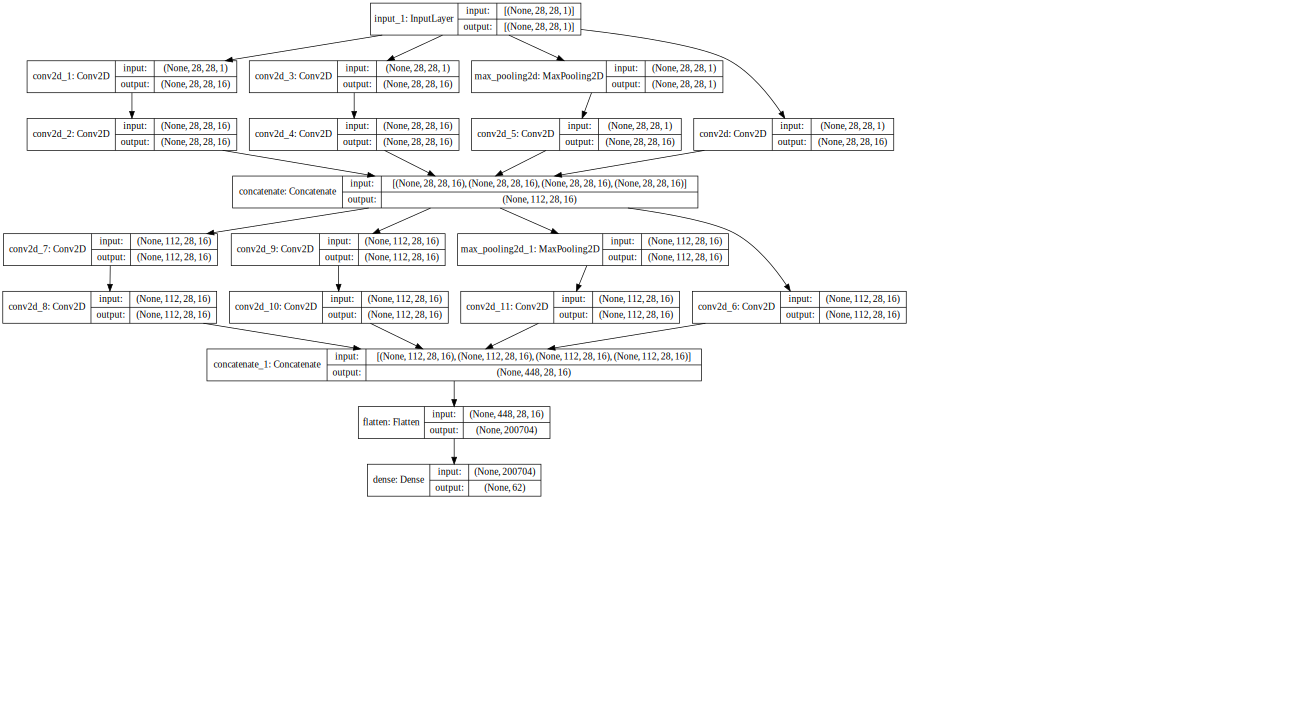

In [24]:
# pydot lib 설치 필요
import pydotplus as pydot
from tensorflow.keras.utils import plot_model

plot_model(inception_Model, to_file='inception_Model.png')

# visualize our model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(inception_Model, show_shapes=True, dpi=50).create(prog='dot', format='svg'))
# SVG(model_to_dot(inception_Model, dpi=50).create(prog='dot', format='svg'))

In [27]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# checkpoint
filepath="model_val_loss.best.hdf5"
checkpoint_acc = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
# Early Stopping
earlyStopping_acc = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

callbacks_list = [checkpoint_acc, earlyStopping_acc]

# optimizer SGD 사용함
optimizer_SGD = keras.optimizers.SGD(momentum=0.9)

inception_Model.compile(loss='categorical_crossentropy',optimizer=optimizer_SGD, metrics=['accuracy'])
history_inception = inception_Model.fit(X_train, y_train,
                                        batch_size=64,
                                        epochs=10,
                                        validation_data=(X_valid, y_valid),
                                        callbacks=callbacks_list)

Epoch 1/10
8725/8725 [==============================] - 2869s 329ms/step - loss: 0.4698 - accuracy: 0.8415 - val_loss: 0.4578 - val_accuracy: 0.8478

Epoch 00001: val_loss improved from inf to 0.45781, saving model to model_val_loss.best.hdf5
Epoch 2/10
8725/8725 [==============================] - 2842s 326ms/step - loss: 0.4236 - accuracy: 0.8532 - val_loss: 0.4461 - val_accuracy: 0.8477

Epoch 00002: val_loss improved from 0.45781 to 0.44609, saving model to model_val_loss.best.hdf5
Epoch 3/10
8725/8725 [==============================] - 2837s 325ms/step - loss: 0.3954 - accuracy: 0.8603 - val_loss: 0.4348 - val_accuracy: 0.8467

Epoch 00003: val_loss improved from 0.44609 to 0.43475, saving model to model_val_loss.best.hdf5
Epoch 4/10
8725/8725 [==============================] - 2836s 325ms/step - loss: 0.3727 - accuracy: 0.8665 - val_loss: 0.4290 - val_accuracy: 0.8476

Epoch 00004: val_loss improved from 0.43475 to 0.42905, saving model to model_val_loss.best.hdf5
Epoch 5/10
8725/

In [28]:
score = inception_Model.evaluate(X_test, y_test)
print('\nTest acc: ', score)

3636/3636 [==============================] - 137s 38ms/step - loss: 0.4225 - accuracy: 0.8507

Test acc:  [0.4225402772426605, 0.8506559133529663]


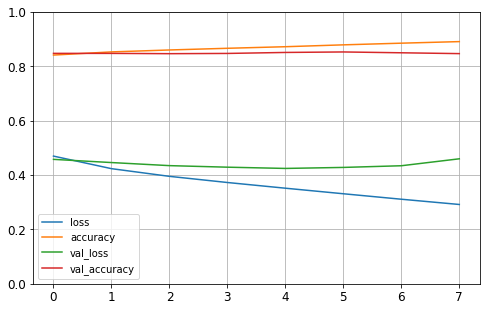

In [29]:
pd.DataFrame(history_inception.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()